In [2]:
# need pip install pandas, matplotlib, numpy
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

races = ['Human','NightElf','Orc','Undead']

In [3]:
# list of functions

# print a 2d dict: d[key1][key] = value
def printDict(wr):
    for race in races:
        wr[race][race] = 0.50
    array = []
    i = -1
    for key in races:
        i += 1
        array.append([])
        array[i].append(wr[key]['Human'])
        array[i].append(wr[key]['NightElf'])
        array[i].append(wr[key]['Orc'])
        array[i].append(wr[key]['Undead'])
    df = pd.DataFrame(array)
    df.columns = races
    df.index = races
    print(df)
        
# check if the game includes two races v1 and v2
def matchRace(match,v1,v2):
    return (match['p1race']==v1 and match['p2race']==v2) or (match['p1race']==v2 and match['p2race']==v1)

# remove punctuation and spaces
def normalize(racename):
    racename = racename.replace('(','')
    racename = racename.replace(')','')
    racename = racename.replace(' ','')
    return racename

# check if two races are the same: Human == Random (Human)
def sameRace(match):
    race1 = normalize(match['p1race']).replace('Random','')
    race2 = normalize(match['p2race']).replace('Random','')
    return race1==race2

# get player's attribute name given the player number and the attribute name.
# playerNumber = 1, var = prace -> p1race
def getVar(playerNumber,var):
    if var[0]=='p':
        return 'p' + str(playerNumber) + var[1:len(var)]
    return var
    
# general win rate by race. ignoreRandom = 0 to include statistics from matches with Random race
def wrbrace(data,ignoreRandom):
    wr = defaultdict(lambda: 0)
    wins = defaultdict(lambda: 0)
    matchCount = defaultdict(lambda: 0)
    for race in races:
        wr[race] = defaultdict(lambda: 0)
        wins[race] = defaultdict(lambda: 0)
        matchCount[race] = defaultdict(lambda: 0)
    
    for game in data:        
        if ignoreRandom==True and ('Random' in game['p1race'] or 'Random' in game['p2race']):
            continue
        
        winner = game['winningPlayer']
        loser = 3 - winner
        
        winnerRace = normalize(game[getVar(winner,'prace')]).replace('Random','')
        loserRace = normalize(game[getVar(loser,'prace')]).replace('Random','')
        if (winnerRace=='' or loserRace==''):
            continue
         
        wins[winnerRace][loserRace] += 1
        matchCount[winnerRace][loserRace] += 1
        matchCount[loserRace][winnerRace] += 1
        wr[winnerRace][loserRace] = round(wins[winnerRace][loserRace] / matchCount[winnerRace][loserRace],4)*100
        wr[loserRace][winnerRace] = round(wins[loserRace][winnerRace] / matchCount[loserRace][winnerRace],4)*100
    
    # wr: win rate % of race1 against race2, 2d dict. wr[race1][race2] = value
    # wins: number of matches that race1 win race2, 2d dict. wins[race1][race2] = value
    # matchCount: number of matches that race1 play vs race2
    return [wr,wins,matchCount]         

# win rate by race by game length.
def wrbtime(data,ignoreRandom):   
    wr = defaultdict(lambda: 0)
    wins = defaultdict(lambda: 0)
    matchCount = defaultdict(lambda: 0)
    wrdist = defaultdict(lambda: 0)
    for race in races:
        wr[race] = defaultdict(lambda: 0)
        wins[race] = defaultdict(lambda: 0)
        matchCount[race] = defaultdict(lambda: 0)
        wrdist[race] = defaultdict(lambda: 0)
        for race2 in races:
            wr[race][race2] = defaultdict(lambda: 0)
            wins[race][race2] = defaultdict(lambda: 0)
            matchCount[race][race2] = defaultdict(lambda: 0)
            wrdist[race][race2] = defaultdict(lambda: 0)
        
    for game in data:        
        if ignoreRandom==True and ('Random' in game['p1race'] or 'Random' in game['p2race']):
            continue
        
        winner = game['winningPlayer']
        loser = 3 - winner
        
        winnerRace = normalize(game[getVar(winner,'prace')]).replace('Random','')
        loserRace = normalize(game[getVar(loser,'prace')]).replace('Random','')
        if (winnerRace=='' or loserRace==''):
            continue
        
        gameLength = game['gameLength']
        wins[winnerRace][loserRace][gameLength] += 1
        matchCount[winnerRace][loserRace][gameLength] += 1
        matchCount[loserRace][winnerRace][gameLength] += 1
        wr[winnerRace][loserRace][gameLength] = round(wins[winnerRace][loserRace][gameLength] / matchCount[winnerRace][loserRace][gameLength],4)*100
        wr[loserRace][winnerRace][gameLength] = round(wins[loserRace][winnerRace][gameLength] / matchCount[loserRace][winnerRace][gameLength],4)*100
    
    for game in data:
        if ignoreRandom==True and ('Random' in game['p1race'] or 'Random' in game['p2race']):
            continue
        
        winner = game['winningPlayer']
        loser = 3 - winner
        
        winnerRace = normalize(game[getVar(winner,'prace')]).replace('Random','')
        loserRace = normalize(game[getVar(loser,'prace')]).replace('Random','')
        if (winnerRace=='' or loserRace==''):
            continue
        
        gameLength = game['gameLength']
        wrdist[winnerRace][loserRace][gameLength] = round(wins[winnerRace][loserRace][gameLength] / sum([wins[winnerRace][loserRace][key] for key in wins[winnerRace][loserRace].keys()]),4) * 100
        wrdist[loserRace][winnerRace][gameLength] = round(wins[loserRace][winnerRace][gameLength] / sum([wins[loserRace][winnerRace][key] for key in wins[loserRace][winnerRace].keys()]),4) * 100
    
    # wr: win rate % by race by game length. 3d dict. wr[race1][race2][gameLength] = value
    
    # wrdist: win rate % distribution by game length. 3d dict. wrdist[race1][race2][gameLength] = value.
    #         wrdist[race1][race2][gameLength] is the % of won games of race1 vs race2 that happen at minute gameLength
    #         For example, if there are in total 1000 HvU matches,
    #         if wrdist['Human']['Undead'][5]==5.5, 
    #         it means 5.5% of the number of HvU victories (= 55) happen at minute 5
    #         sum(wrdist[race1][race2])==100% for all pair race1, race2
             
    return [wr,wrdist,wins,matchCount]      

def getAverageWinTime(data,ignoreRandom):
    wrtdist = wrbtime(data,ignoreRandom)[1]
    
    wt = defaultdict(lambda: 0)
    for race in races:
        wt[race] = defaultdict(lambda: 0)
    
    for race1 in races:
        for race2 in races:
            if race1==race2:
                wt[race1][race2] = 0.0
                continue
            # expected value = sum(probability[i] * value[i])
            wt[race1][race2] = sum([wrtdist[race1][race2][gameLength]/100*gameLength for gameLength in wrtdist[race1][race2].keys()])
    
    return wt

def getWinrateByFirstHero(data,ignoreRandom):
    wr = defaultdict(lambda: 0)
    wins = defaultdict(lambda: 0)
    matchCount = defaultdict(lambda: 0)
    wrdist = defaultdict(lambda: 0)
    for race in races:
        wr[race] = defaultdict(lambda: 0)
        wins[race] = defaultdict(lambda: 0)
        matchCount[race] = defaultdict(lambda: 0)
        wrdist[race] = defaultdict(lambda: 0)
        for race2 in races:
            wr[race][race2] = defaultdict(lambda: 0)
            wins[race][race2] = defaultdict(lambda: 0)
            matchCount[race][race2] = defaultdict(lambda: 0)
            wrdist[race][race2] = defaultdict(lambda: 0)
    
    for game in data:
        if ignoreRandom==True and ('Random' in game['p1race'] or 'Random' in game['p2race']):
            continue
        
        winner = game['winningPlayer']
        loser = 3 - winner
        
        winnerRace = normalize(game[getVar(winner,'prace')]).replace('Random','')
        loserRace = normalize(game[getVar(loser,'prace')]).replace('Random','')
        if (winnerRace=='' or loserRace==''):
            continue
        
        p1hero = game[getVar(winner,'pFirstHeroName')]
        p2hero = game[getVar(loser,'pFirstHeroName')] 
        hero1hero2 = p1hero + '-' + p2hero
        hero2hero1 = p2hero + '-' + p1hero
        
        wins[winnerRace][loserRace][hero1hero2] += 1
        matchCount[winnerRace][loserRace][hero1hero2] += 1
        matchCount[loserRace][winnerRace][hero2hero1] += 1
        wr[winnerRace][loserRace][hero1hero2] = round(wins[winnerRace][loserRace][hero1hero2] / matchCount[winnerRace][loserRace][hero1hero2],4)*100
        wr[loserRace][winnerRace][hero2hero1] = round(wins[loserRace][winnerRace][hero2hero1] / matchCount[loserRace][winnerRace][hero2hero1],4)*100
    
    return [wr,wins,matchCount]

def wrbfhSorted(wrbfh,race1,race2):
    wr = wrbfh[0]
    matchCount = wrbfh[2]
    heropairWr = wr[race1][race2]
    heropairCount = matchCount[race1][race2]
    
    totalMatch = sum([heropairCount[key] for key in heropairCount.keys()])
    pairname = []
    pairwr = []
    pairfrequency = []
    for key in heropairWr.keys():
        pairname.append(key)
        pairwr.append(heropairWr[key])
        pairfrequency.append(round(heropairCount[key]/totalMatch,4)*100)
    
    # sort hero pairs in decreasing order of frequency
    # return [hero pair names, hero pair win rate, hero pair frequency]
    return [[[ele[2],ele[1],ele[0]] for ele in sorted(zip(pairfrequency,pairwr,pairname),reverse=True)],totalMatch]


In [5]:
f = open('total.csv')
lines = [line.split(',') for line in f]

m = len(lines) # number of sample games
n = 63  # number of attributes of each game
data = []
for i in range(1,len(lines)):
    data.append({})
    for j in range(n):
        try:
            data[i-1][lines[0][j]] = lines[i][j]
        except:
            print(str(i) + ' ' + str(j))
            
        try: # convert attributes like gold mined, lumber harvested, ... to integer
            data[i-1][lines[0][j]] = int(data[i-1][lines[0][j]])
        except: # do nothing
            b = 1 
att = lines[0]
rawData = data

In [6]:
# remove game with same race, 
data = [game for game in data if not sameRace(game)]            
            
#remove all game with <= 2 minute
data = [game for game in data if game['gameLength']>2]

# 1 or 2 afk: no unit production, no hero, or forgot to mine gold in games < 10 minutes
# 56507
data = [game for game in data if ((game['p1unitsProduced']>5 or game['p1unitsKilled']>1) 
and (game['p2unitsProduced']>5 or game['p2unitsKilled']>1))]

# 56088, 
data = [game for game in data if game['p1FirstHeroName']!='' and game['p2FirstHeroName']!='']

# 55897
data = [game for game in data 
        if ((game['p1goldMined']>10*(game['gameLength']-3)*60 and game['p2goldMined']>10*(game['gameLength']-3)*60)
            or game['gameLength']>10) and game['p1lumberHarvested']>0 and game['p2lumberHarvested']>0]


In [7]:
# this value is equal to the conclusion value from this post: 
# https://warcraft3.info/articles/278/battlenet-statistics-1304-winrates
wr = wrbrace(rawData,0)[0]
printDict(wr)


          Human  NightElf    Orc  Undead
Human      0.50     49.98  51.09   46.39
NightElf  50.02      0.50  51.39   47.87
Orc       48.91     48.61   0.50   48.52
Undead    53.61     52.13  51.48    0.50


In [9]:
maps = set([game['map'] for game in data])    
laddermaps = ['Amazonia','Concealed Hill','Echo Isles','Last Refuge','Northern Isles','Swamped Temple','Terenas Stand_ L V','Twisted Meadows']
mapwr = {}
mapwrran = {} # win rate including random players
mapMatchCount = {}

# calculate general win rate by race
for mapname in maps:
    games = [game for game in data if game['map']==mapname]
    tmp = wrbrace(games,1)
    mapwr[mapname] = tmp[0]
    mapMatchCount[mapname] = tmp[2]

# calculate general win rate by race including random players
for mapname in maps:
    games = [game for game in data if game['map']==mapname]
    mapwrran[mapname] = wrbrace(games,0)[0]

In [10]:
# replace mapwr by mapwrran to see statitics includng random players.
# if you do so, you also have to assign mapMatchCount value using general win rate including random
for mapname in laddermaps:
    print(mapname)
    printDict(mapwr[mapname])
    print('\n')

Amazonia
          Human  NightElf    Orc  Undead
Human      0.50     47.79  50.13   46.39
NightElf  52.21      0.50  51.35   51.02
Orc       49.87     48.65   0.50   48.50
Undead    53.61     48.98  51.50    0.50


Concealed Hill
          Human  NightElf    Orc  Undead
Human      0.50     52.64  54.62   49.31
NightElf  47.36      0.50  54.34   43.62
Orc       45.38     45.66   0.50   44.76
Undead    50.69     56.38  55.24    0.50


Echo Isles
          Human  NightElf    Orc  Undead
Human      0.50     53.29  53.29   48.72
NightElf  46.71      0.50  48.54   48.58
Orc       46.71     51.46   0.50   50.57
Undead    51.28     51.42  49.43    0.50


Last Refuge
          Human  NightElf    Orc  Undead
Human      0.50     50.12  52.35   44.40
NightElf  49.88      0.50  54.13   48.09
Orc       47.65     45.87   0.50   48.65
Undead    55.60     51.91  51.35    0.50


Northern Isles
          Human  NightElf    Orc  Undead
Human      0.50     48.47  48.77   45.29
NightElf  51.53      0.50  5

In [11]:
# number of games played by map/race
for mapname in laddermaps:
    print(mapname)
    printDict(mapMatchCount[mapname])
    print('\n')

Amazonia
          Human  NightElf    Orc  Undead
Human       0.5     657.0  790.0   664.0
NightElf  657.0       0.5  668.0   586.0
Orc       790.0     668.0    0.5   666.0
Undead    664.0     586.0  666.0     0.5


Concealed Hill
          Human  NightElf    Orc  Undead
Human       0.5     549.0  714.0   578.0
NightElf  549.0       0.5  565.0   486.0
Orc       714.0     565.0    0.5   563.0
Undead    578.0     486.0  563.0     0.5


Echo Isles
           Human  NightElf     Orc  Undead
Human        0.5     775.0  1064.0   858.0
NightElf   775.0       0.5   789.0   706.0
Orc       1064.0     789.0     0.5   872.0
Undead     858.0     706.0   872.0     0.5


Last Refuge
          Human  NightElf    Orc  Undead
Human       0.5     816.0  959.0   795.0
NightElf  816.0       0.5  739.0   655.0
Orc       959.0     739.0    0.5   777.0
Undead    795.0     655.0  777.0     0.5


Northern Isles
          Human  NightElf    Orc  Undead
Human       0.5     392.0  488.0   435.0
NightElf  392.0   

In [12]:
# get average win time for each map
for mapname in laddermaps:
    print(mapname)
    games = [game for game in data if game['map']==mapname]
    printDict(getAverageWinTime(games,1))
    print('\n')


Amazonia
            Human  NightElf      Orc   Undead
Human      0.5000   14.1736  14.0396  15.4455
NightElf  14.8581    0.5000  14.2826  15.7844
Orc       14.0064   13.4929   0.5000  15.8203
Undead    15.4451   15.9850  15.2850   0.5000


Concealed Hill
            Human  NightElf      Orc   Undead
Human      0.5000   15.9724  15.4333  16.9446
NightElf  15.7382    0.5000  16.5668  16.1694
Orc       15.9203   15.1524   0.5000  16.9652
Undead    16.8663   17.2124  16.4000   0.5000


Echo Isles
            Human  NightElf      Orc   Undead
Human      0.5000   14.1819  15.0274  16.3086
NightElf  14.4928    0.5000  15.1661  16.8605
Orc       14.5695   14.2143   0.5000  15.8985
Undead    16.9160   15.3790  15.9162   0.5000


Last Refuge
            Human  NightElf      Orc   Undead
Human      0.5000   15.1994  15.9153  16.4264
NightElf  15.4401    0.5000  15.3400  16.0298
Orc       14.2283   14.4710   0.5000  15.4790
Undead    16.7984   16.2166  16.1860   0.5000


Northern Isles
          

In [13]:
# get average win rate by first hero for each map
# can only see 1 pair race at a time, otherwise it will print all 12 pairs of races, and that's too long
for mapname in laddermaps:
    print(mapname)
    print('Hero pair\tWin rate\tAppearance frequency')
    games = [game for game in data if game['map']==mapname]
    
    wrbfh = getWinrateByFirstHero(games,1)
    race1 = 'Human'
    race2 = 'Undead'
    wrbfhSelected = wrbfhSorted(wrbfh,race1,race2)
    for x in wrbfhSelected[0]:
        print(x)
        
    print('Total matches: ' + str(wrbfhSelected[1]))
    print('\n')


Amazonia
Hero pair	Win rate	Appearance frequency
['Archmage-Death Knight', 48.339999999999996, 40.81]
['Mountain King-Death Knight', 37.230000000000004, 14.16]
['Paladin-Death Knight', 51.81, 12.5]
['Archmage-Dread Lord', 60.870000000000005, 6.93]
['Archmage-Crypt Lord', 40.0, 4.52]
['Archmage-Lich', 33.33, 3.61]
['Mountain King-Dread Lord', 38.1, 3.16]
['Paladin-Dread Lord', 50.0, 1.81]
['Paladin-Crypt Lord', 66.67, 1.3599999999999999]
['Mountain King-Lich', 33.33, 1.3599999999999999]
['Mountain King-Crypt Lord', 33.33, 1.3599999999999999]
['Blood Mage-Death Knight', 50.0, 1.2]
['Paladin-Lich', 66.67, 0.8999999999999999]
['Archmage-Goblin Tinker', 100.0, 0.6]
['Mountain King-Firelord', 66.67, 0.44999999999999996]
['Pit Lord-Death Knight', 33.33, 0.44999999999999996]
['Mountain King-Dark Ranger', 33.33, 0.44999999999999996]
['Archmage-Firelord', 0.0, 0.44999999999999996]
['Archmage-Dark Ranger', 100.0, 0.3]
['Blood Mage-Lich', 50.0, 0.3]
['Blood Mage-Dread Lord', 50.0, 0.3]
['Alchemist

['Archmage-Death Knight', 43.24, 34.77]
['Mountain King-Death Knight', 53.620000000000005, 12.97]
['Paladin-Death Knight', 56.599999999999994, 9.959999999999999]
['Archmage-Dread Lord', 46.51, 8.08]
['Archmage-Crypt Lord', 46.43, 5.26]
['Archmage-Lich', 54.55, 4.14]
['Mountain King-Dread Lord', 40.910000000000004, 4.14]
['Paladin-Dread Lord', 38.89, 3.38]
['Paladin-Crypt Lord', 18.18, 2.07]
['Mountain King-Lich', 50.0, 1.8800000000000001]
['Paladin-Lich', 25.0, 1.5]
['Blood Mage-Death Knight', 12.5, 1.5]
['Mountain King-Crypt Lord', 42.86, 1.32]
['Archmage-Dark Ranger', 66.67, 1.13]
['Paladin-Dark Ranger', 100.0, 0.75]
['Firelord-Death Knight', 25.0, 0.75]
['Goblin Tinker-Death Knight', 33.33, 0.5599999999999999]
['Dark Ranger-Death Knight', 100.0, 0.38]
['Archmage-Goblin Tinker', 100.0, 0.38]
['Mountain King-Firelord', 50.0, 0.38]
['Blood Mage-Dread Lord', 50.0, 0.38]
['Mountain King-Dark Ranger', 0.0, 0.38]
['Goblin Tinker-Crypt Lord', 0.0, 0.38]
['Blood Mage-Crypt Lord', 0.0, 0.38]


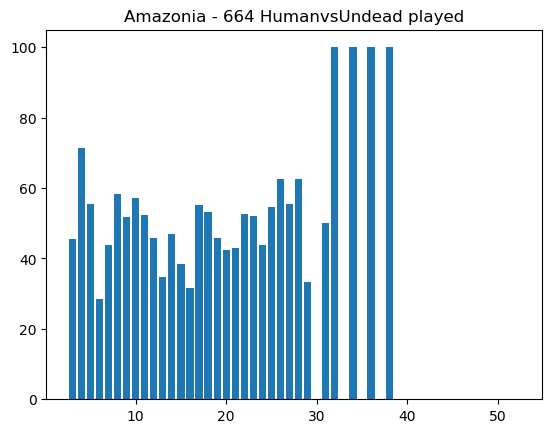

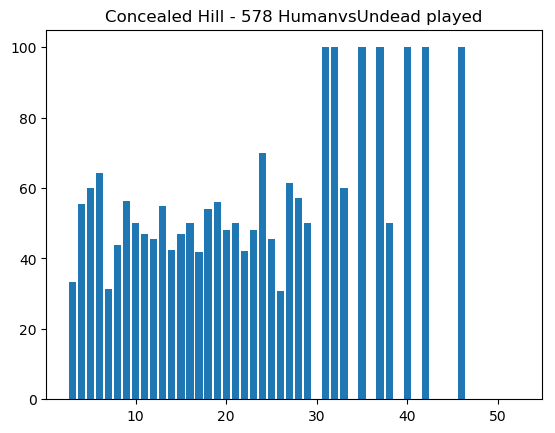

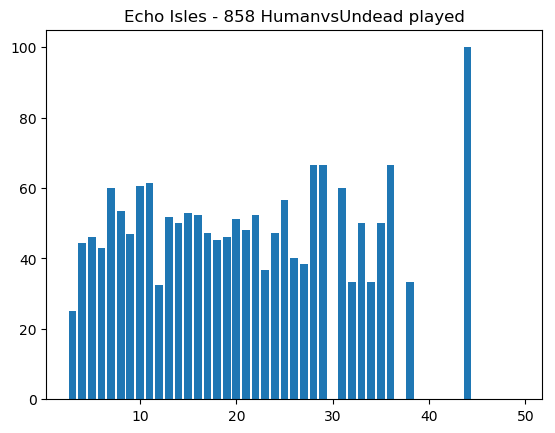

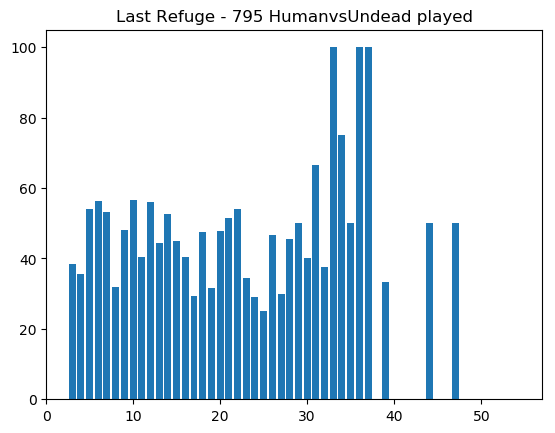

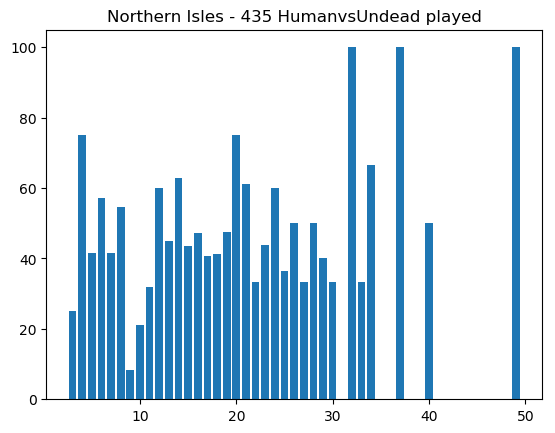

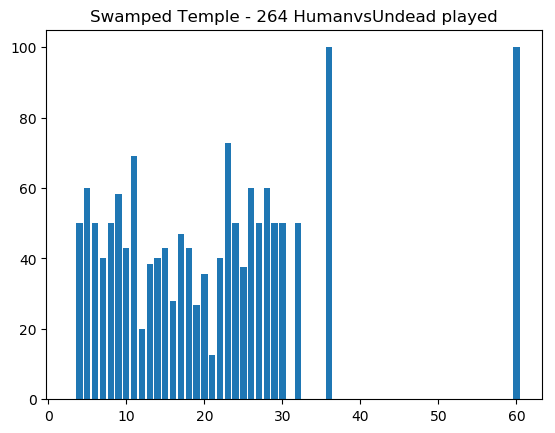

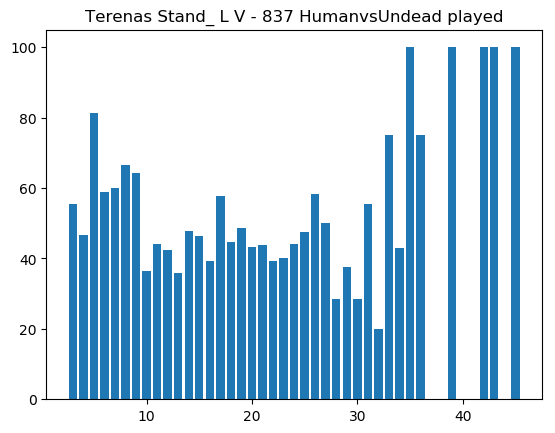

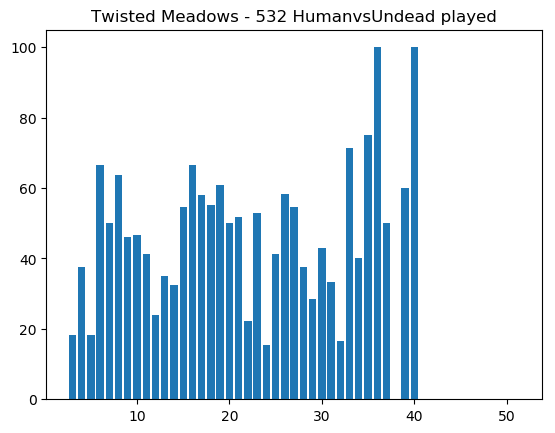

In [14]:
# get win rate by game length for each map.
# can only see 1 race pair each time because it requires drawing graphs, a lot of graphs
# each (x,y) value: when the game ends at x minute, there's y% chance that's race1 is the victor
for mapname in laddermaps:
    games = [game for game in data if game['map']==mapname]
    tmp = wrbtime(games,1)
    wrt = tmp[0]
    wrtdist = tmp[1]
    
    race1 = 'Human'
    race2 = 'Undead'
    gameLengths = sorted([key for key in wrt[race1][race2].keys()])
    gamePlayed = len([game for game in games if matchRace(game,race1,race2)])
    plt.figure()
    plt.title(mapname + ' - ' + str(gamePlayed) + ' ' + str(race1) + 'vs' + str(race2) + ' played')
    plt.bar(gameLengths[0:40],[wrt[race1][race2][gameLength] for gameLength in gameLengths[0:40]])


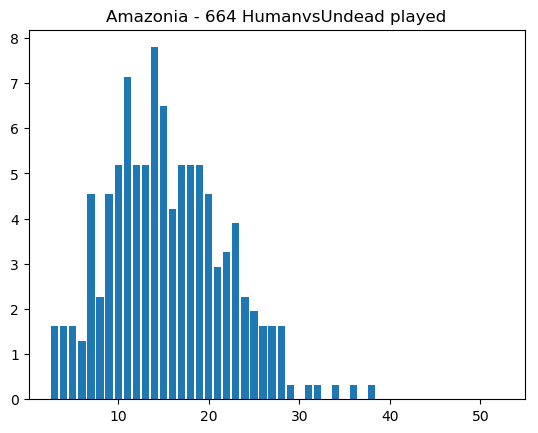

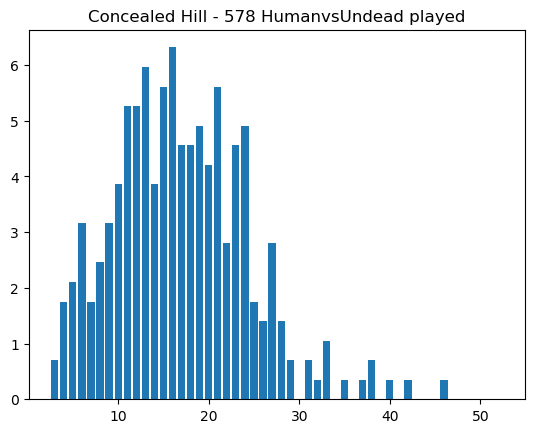

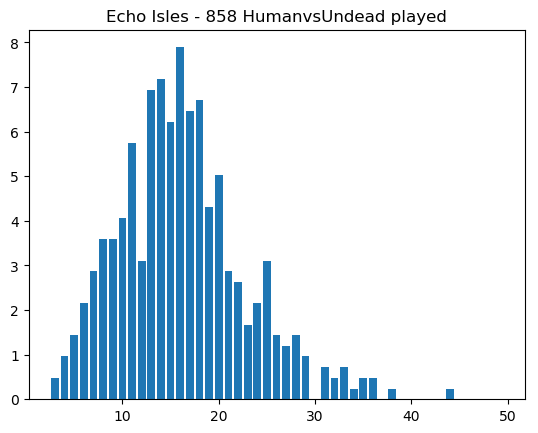

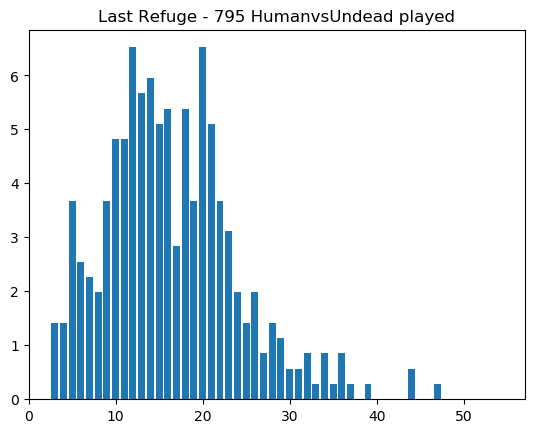

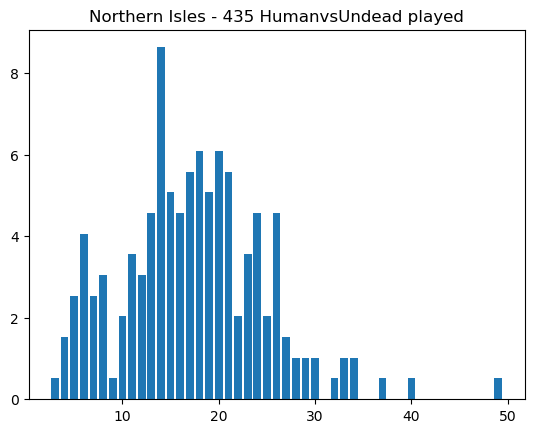

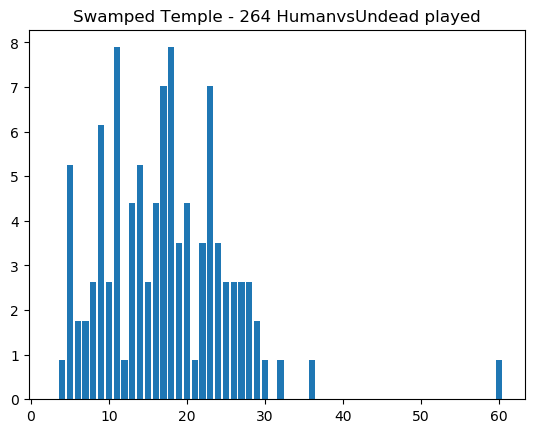

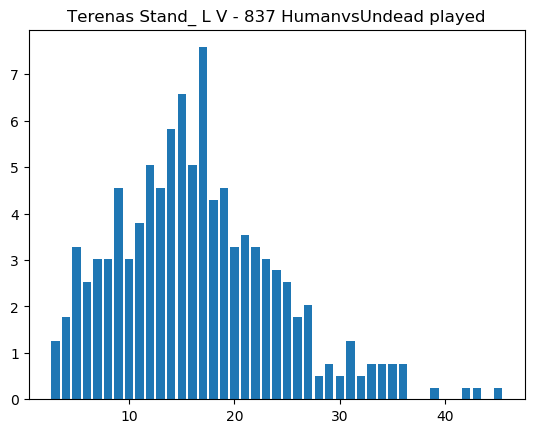

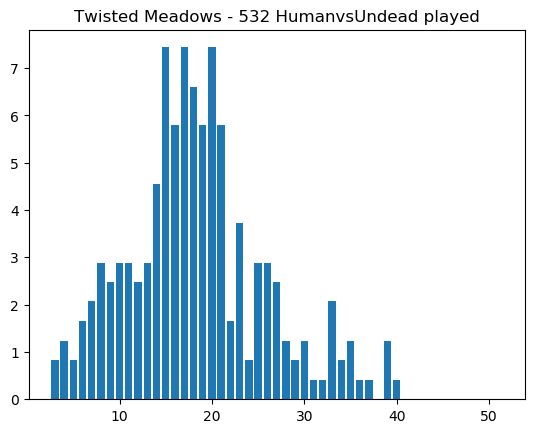

In [15]:
# get win rate distribution by game length for each map.
# can only see 1 race pair each time because it requires drawing graphs, a lot of graphs
# each (x,y) value: y is the % of victories of race1 against race2 that happens at minute x
# sum of all bar equals 100%
for mapname in laddermaps:
    games = [game for game in data if game['map']==mapname]
    tmp = wrbtime(games,1)
    wrt = tmp[0]
    wrtdist = tmp[1]
    
    race1 = 'Human'
    race2 = 'Undead'
    gameLengths = sorted([key for key in wrt[race1][race2].keys()])
    gamePlayed = len([game for game in games if matchRace(game,race1,race2)])
    plt.figure()
    plt.title(mapname + ' - ' + str(gamePlayed) + ' ' + str(race1) + 'vs' + str(race2) + ' played')
    plt.bar(gameLengths[0:40],[wrtdist[race1][race2][gameLength] for gameLength in gameLengths[0:40]])    